# Import Library

In [1]:
import os
import fnmatch as fn
import numpy as np
import pandas as pd
#!pip install dbfread
import dbfread

#!pip install pandas_profiling
import pandas_profiling as pp
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import font_manager, rc
%matplotlib inline
#%matplotlib notebook

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from math import sin,cos,sqrt,atan2,radians 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
import tbats
#import fbprophet

import requests
import logging
import time
import googlemaps
import reverse_geocoder
import pprint
import folium
import zipfile
import json
#%matplotlib.inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from xgboost import XGBRegressor
import lightgbm as lgb


matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 기호도 표시

# 한글 깨짐 방지 목적 #
font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family = font_name)

## 맥
# rc('font', family='/Library/Fonts/AppleGothic.ttf')


# 만약 plotly가 설치 되지 않았을 경우 하단의 코드를 실행할 것 #
#!pip install plotly
import plotly
#!pip install cufflinks
#import plotly.express as px
# Cufflinks wrapper on plotly
import cufflinks as cf
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
from plotly.offline import init_notebook_mode, plot,iplot

init_notebook_mode(connected = True)
cf.go_offline()

import warnings
warnings.filterwarnings(action='ignore') # 경고 메시지를 숨길 때

# Import Data

In [2]:
df = pd.read_csv('가공데이터/merge_유통_유동_환경_소상공인_edit1.csv')
df = df.iloc[:,1:]
df['date'] = pd.to_datetime(df['date'],format = '%Y-%m-%d')

df_revised = pd.read_csv('가공데이터/merge_유통_유동_환경_소상공인_edit2.csv')
df_revised = df_revised.iloc[:,1:]
df_revised['date'] = pd.to_datetime(df_revised['date'],format = '%Y-%m-%d')

gs_retail = pd.read_csv('가공데이터/GS편의점_종로노원구.csv')
gs_retail = gs_retail.iloc[:,1:]

tp_revised = pd.read_csv('가공데이터/유동_edit1.csv')
tp_revised = tp_revised.iloc[:,1:]
tp_revised = tp_revised.drop(['STD_YM','STD_YMD','HDONG_CD'],axis=1)
tp_revised['date'] = pd.to_datetime(tp_revised['date'],format='%Y-%m-%d')

In [ ]:
df_revised

In [18]:
shape_visual = gpd.read_file('Rawdata/유동인구데이터/행정동경계파일/종로_노원_행정동.shp',
                             encoding = 'euckr')

ad = dbfread.DBF('Rawdata/유동인구데이터/행정동경계파일/종로_노원_행정동.dbf')
ad = pd.DataFrame(iter(ad))

ad['X_COORD'] = ad['X_COORD'].apply(float)
ad['Y_COORD'] = ad['Y_COORD'].apply(float)

g_info = [Point(i) for i in zip(ad['X_COORD'],ad['Y_COORD'])]

geo_ad = gpd.GeoDataFrame(ad,
                          crs = {'init' : 'epsg:4326'},
                          geometry = g_info
                         )
geo_ad.head()

,STD_YYYY,HDONG_CD,HDONG_NM,SIDO_CD,SIDO_NM,SGNG_CD,SGNG_NM,AREA,LENGTH,X_COORD,Y_COORD,geometry
0,2019,1111051500,청운효자동,11,서울특별시,11110,종로구,2573175.62,7975.05,126.972694,37.581306,POINT (126.972694 37.581306)
1,2019,1111053000,사직동,11,서울특별시,11110,종로구,1128161.02,5498.40,126.970919,37.573408,POINT (126.9709195 37.573408)
2,2019,1111054000,삼청동,11,서울특별시,11110,종로구,1478468.25,7377.76,126.984028,37.582083,POINT (126.984028 37.582083)
3,2019,1111055000,부암동,11,서울특별시,11110,종로구,2276588.99,8912.71,126.966500,37.589917,POINT (126.9665 37.589917)
4,2019,1111056000,평창동,11,서울특별시,11110,종로구,8951336.18,13312.43,126.968972,37.602583,POINT (126.968972 37.602583)


# GS 계열사와 {종로구,노원구}의 지리적 속성을 활용하여 변수들간의 관계를 파악해보자

## 동별 Polygon 정보를 시각화하면 다음과 같다.

No handles with labels found to put in legend.


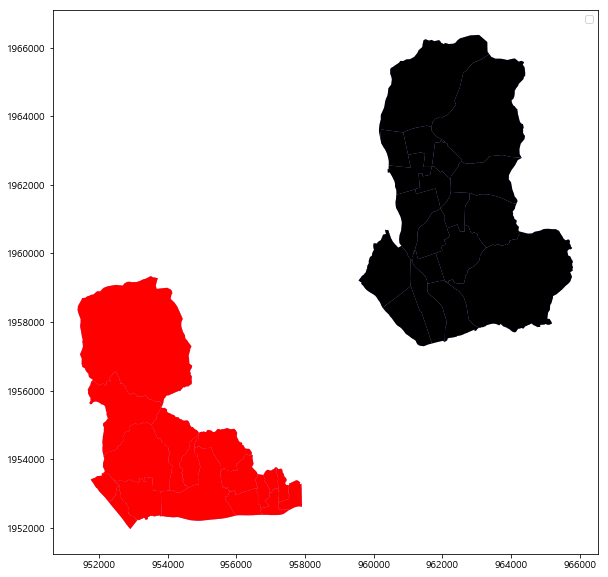

In [19]:
fig,ax = plt.subplots(figsize = (10,10))
shape_visual.plot(ax = ax, alpha=0.4,color = 'blue')
shape_visual[shape_visual['SGNG_CD'] == '11110'].plot(ax = ax, color = 'red',label='노원구')
shape_visual[shape_visual['SGNG_CD'] == '11350'].plot(ax = ax, color = 'black',label='종로구')
#ax.set_title('노원구 & 종로구')
plt.legend()

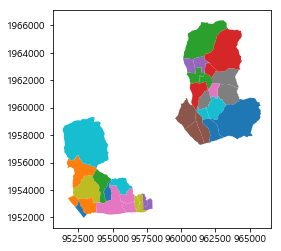

In [20]:
ax = shape_visual.plot(column = 'HDONG_NM')

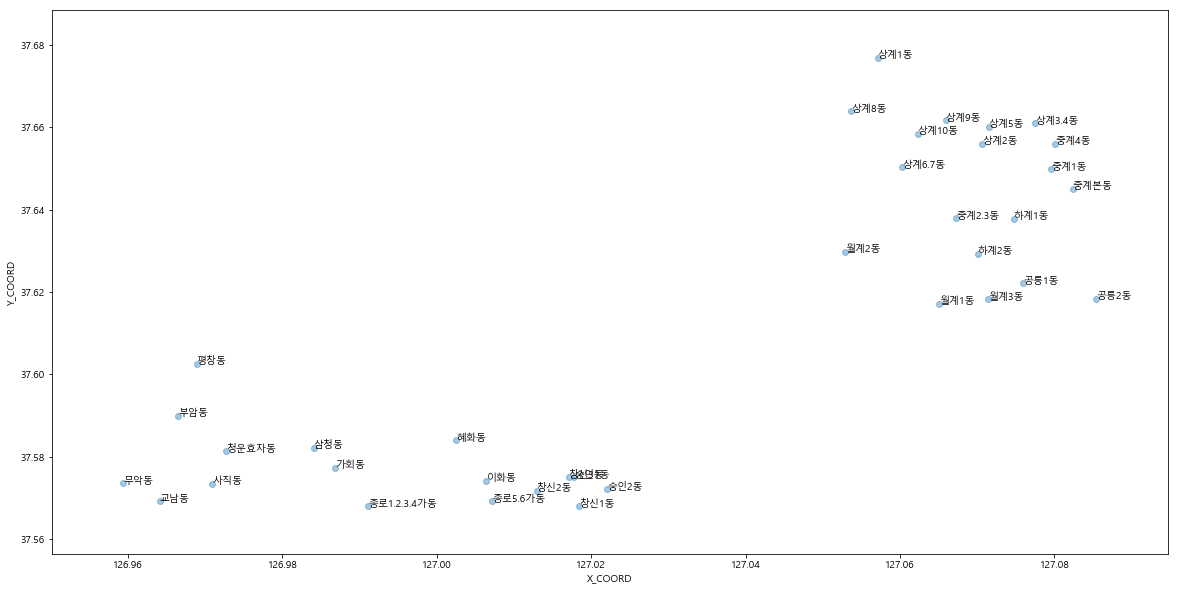

In [21]:
plt.figure(figsize = (20,10))
plt.scatter(geo_ad['X_COORD'],
            geo_ad['Y_COORD'],
            cmap = "YlOrRd",
            alpha = 0.4)
plt.xlabel('X_COORD')
plt.ylabel('Y_COORD')

for i in range(len(geo_ad['HDONG_NM'])):
    plt.text(geo_ad['X_COORD'][i],geo_ad['Y_COORD'][i],geo_ad['HDONG_NM'][i])

In [22]:
gs_retail.head()

,상호명,지점명,상권업종대분류명,상권업종중분류명,상권업종소분류명,표준산업분류명,시도명,시군구명,행정동명,법정동명,지번주소,건물명,도로명주소,경도,위도,time
0,GS25광운문화관,NaN,소매,종합소매점,편의점,체인화 편의점,서울특별시,노원구,월계1동,월계동,서울특별시 노원구 월계동 466,광운대학교,서울특별시 노원구 광운로 21,127.057576,37.619816,2018-03-31
1,GS25,명륜스타점,소매,종합소매점,편의점,체인화 편의점,서울특별시,종로구,혜화동,명륜4가,서울특별시 종로구 명륜4가 113-1,대학로스타시스빌딩,서울특별시 종로구 대학로11길 23,127.000401,37.582052,2018-03-31
2,GS25석계그랑빌,NaN,소매,종합소매점,편의점,체인화 편의점,서울특별시,노원구,월계3동,월계동,서울특별시 노원구 월계동 18,그랑빌아파트,서울특별시 노원구 마들로 31,127.067060,37.618720,2018-03-31
3,GS노원중앙점,노원중앙점,소매,종합소매점,편의점,체인화 편의점,서울특별시,노원구,상계6.7동,상계동,서울특별시 노원구 상계동 725-4,영보빌딩,서울특별시 노원구 동일로218길 41,127.063160,37.654172,2018-03-31
4,지에스25상명사랑,NaN,소매,종합소매점,편의점,체인화 편의점,서울특별시,종로구,부암동,홍지동,서울특별시 종로구 홍지동 94-2,NaN,서울특별시 종로구 세검정로 230,126.958506,37.600143,2018-03-31


## 소상공인데이터에 등록된 가장 최신의 GS 편의점 좌표 정보[노원구,종로구]를 시각화하면 다음과 같다. 

In [23]:
gs_retail_recent = gs_retail[gs_retail['time'] == '2019-03-31']
gs_recent_loca = [list(i) for i in zip(gs_retail_recent['위도'],gs_retail_recent['경도'])]

In [24]:
t1 = folium.Map(location = [37.581306,126.972694],zoom_start=10)
for j in gs_recent_loca:
    folium.Marker(j).add_to(t1)
t1

In [25]:
g_no = gs_retail_recent[gs_retail_recent['시군구명'] == '노원구']
g_jo = gs_retail_recent[gs_retail_recent['시군구명'] == '종로구']

g_no_loca = [list(i) for i in zip(g_no['위도'],g_no['경도'])]
g_jo_loca = [list(i) for i in zip(g_jo['위도'],g_jo['경도'])]

In [26]:
t2 = folium.Map(location = [37.581306,126.972694],zoom_start=10)

for i in range(len(g_no_loca)):
    folium.Circle(radius = 100,
                  location = g_no_loca[i],
                  color = 'crimson',
                  fill=False).add_to(t2)

for i in range(len(g_jo_loca)):
    folium.Circle(radius = 100,
                  location = g_jo_loca[i],
                  color = 'blue',
                  fill=False).add_to(t2)
t2

- http://www.gisdeveloper.co.kr/?p=2332 : 동에 대한 shape file 제공{dbf,shp,shx,prj format file}
- http://www.gisdeveloper.co.kr/?p=2101 : UTM-k(GRS80 타원체) -> 경위도 좌표계
    - 기존에 제공된 데이터에서 Polygon 속성값은 UTM-k['GRS80 타원체']좌표계를 쓰고 있다. 타데이터와 매칭시키기 위해서 경위도 좌표계를 도입하여 변환한다.
- https://mapshaper.org/ : shp file -> Json file
    - 지리적 속성값들을 면밀히 살리기 위해서 기존에 shp파일을 Json파일로 변환한다.

In [27]:
tt = pd.DataFrame(gs_retail_recent.groupby(['행정동명']).size())
#tt = pd.DataFrame(gs_retail_recent['행정동명'].value_counts())
tt['HDONG_NM'] = tt.index

### 각 동 및 세그멘트별로 보았을 때, 각 동별 편의점의 수들이 유동인구의 밀도값과 상당히 유사한 값들을 가짐을 확인할 수 있다.

다음은 유동인구의 동별 중위값이다.

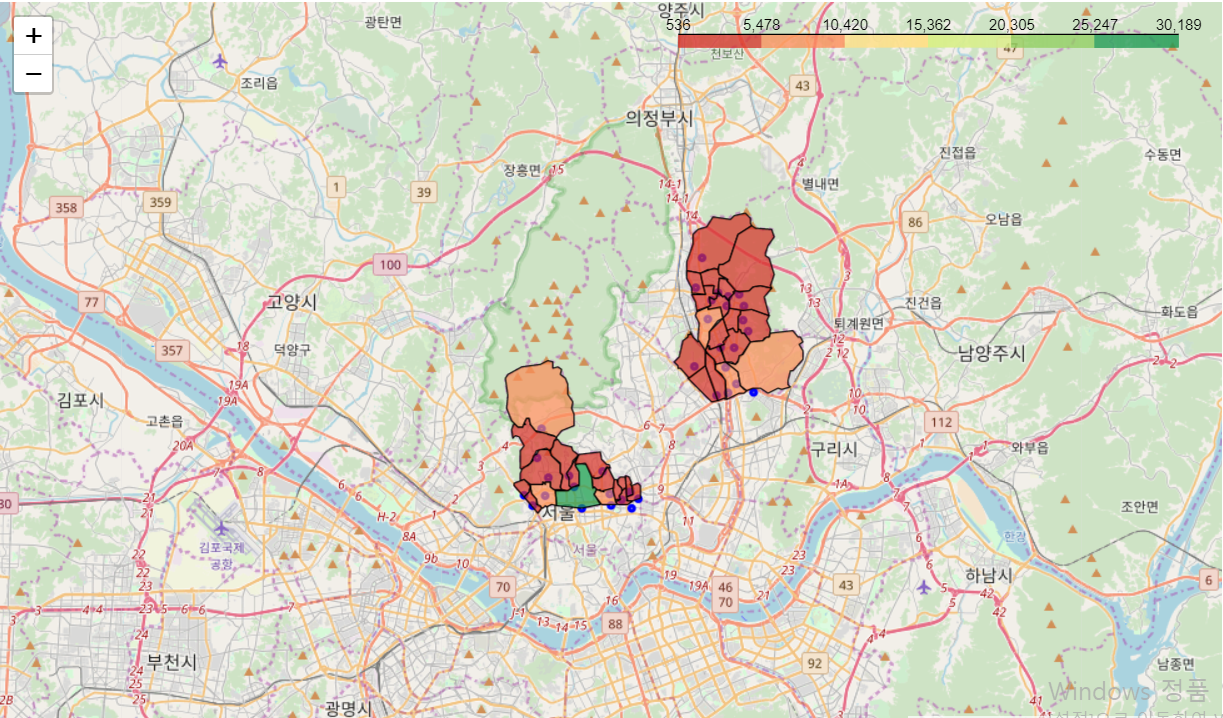

In [31]:
rfile = open(r'Rawdata/유동인구데이터\행정동경계파일\종로_노원_행정동_wgs84.json','r',encoding='utf-8').read()
jsondata = json.loads(rfile)

jongro_nowon_map = folium.Map(location = [np.mean(geo_ad['Y_COORD']),np.mean(geo_ad['X_COORD'])],
                              zoom_start = 10)

jongro_nowon_map.choropleth(geo_data = jsondata,
                            data =tt , 
                            columns = ['HDONG_NM',0],
                            key_on='feature.properties.HDONG_NM',
                            fill_opacity=0.7,
                           fill_color='RdPu'
                            )

jongro_nowon_map

### 또한 각 동을 기준으로 보았을 때, 유통지수가 유동인구의 밀도값과 상당히 유사한 값들을 가짐을 확인할 수 있다.

In [32]:
tt2 = pd.DataFrame(df.groupby(['district'])['values'].mean())
tt2['district'] = tt2.index

In [33]:
rfile = open(r'Rawdata/유동인구데이터\행정동경계파일\종로_노원_행정동_wgs84.json','r',encoding='utf-8').read()
jsondata = json.loads(rfile)

jongro_nowon_map = folium.Map(location = [np.mean(geo_ad['Y_COORD']),np.mean(geo_ad['X_COORD'])],
                              zoom_start = 10)

jongro_nowon_map.choropleth(geo_data = jsondata,
                            data =tt2, 
                            columns = ['district','values'],
                            key_on='feature.properties.HDONG_NM',
                            fill_opacity=0.7,
                            fill_color='RdPu'
                            )
jongro_nowon_map